## Naive Bayes

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.model_selection as cv
import seaborn as sn


from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB       
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_val_predict  
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

df = pd.read_csv('../feature_selection.csv')
df.head()

,koi_period,koi_period_err1,koi_period_err2,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_duration_err1,koi_duration_err2,koi_depth,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,dec,koi_disposition
0,101.110701,0.000953,-0.000953,0.008060,-0.008060,0.0460,0.2100,-0.2100,878.1,1.61,0.10,-0.08,229.0,0.65,0.14,-0.11,24.1,4133.0,74.0,-82.0,0.023,-0.033,0.561,0.033,41.452209,1
1,4.800654,0.000004,-0.000004,0.000745,-0.000745,0.7850,0.0550,-0.0550,15304.0,16.91,6.01,-2.00,1347.0,778.45,793.72,-255.78,298.0,6715.0,161.0,-241.0,0.056,-0.224,1.241,0.441,38.999008,0
2,39.593105,0.000615,-0.000615,0.014000,-0.014000,0.0044,0.5980,-0.5980,156.6,1.22,0.51,-0.11,546.0,21.06,26.65,-6.05,5.7,6046.0,172.0,-218.0,0.044,-0.298,0.972,0.411,41.659611,0
3,31.158825,0.000057,-0.000057,0.001380,-0.001380,0.0290,0.0504,-0.0504,959.0,3.56,0.57,-0.46,639.0,39.46,17.49,-11.96,73.6,5951.0,107.0,-119.0,0.120,-0.120,1.155,0.184,38.710232,1
4,613.829050,0.032600,-0.032600,0.031900,-0.031900,0.2616,1.4000,-1.4000,148.2,2.85,1.25,-1.41,307.0,2.10,2.78,-1.62,10.2,5636.0,173.0,-148.0,0.459,-0.224,2.357,1.027,43.824032,0


<Figure size 453.3x280.155 with 0 Axes>

In [17]:
y_kepler = df['koi_disposition']
X_kepler = df.drop('koi_disposition', axis=1)
(X_train, X_test, y_train, y_test) = cv.train_test_split(X_kepler, y_kepler, test_size=.3, stratify = y_kepler, random_state=1)

Separate the data (30% test)

Without normalization

In [3]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred=gnb.predict(X_test)
print("Confusion matrix on test set:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy on test set: ", accuracy_score(y_test, y_pred))

Confusion matrix on test set:
 [[208 200]
 [  3 189]]

Accuracy on test set:  0.6616666666666666


### Normalization

#### StandardScaler

In [4]:
#Mean = 0, Std = 1
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [5]:
gnb = GaussianNB()
gnb.fit(X_train_sc, y_train)
y_pred=gnb.predict(X_test_sc)
print("Confusion matrix on test set:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy on test set: ", accuracy_score(y_test, y_pred))

Confusion matrix on test set:
 [[287 121]
 [  2 190]]

Accuracy on test set:  0.795


#### Power Transformer

In [6]:
# Apply a power transform featurewise to make data more Gaussian-like.
scaler = preprocessing.PowerTransformer().fit(X_train)
X_train_pt = scaler.transform(X_train)
X_test_pt = scaler.transform(X_test)

In [7]:
gnb = GaussianNB()
gnb.fit(X_train_pt, y_train)
y_pred=gnb.predict(X_test_pt)
print("Confusion matrix on test set:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy on test set: ", accuracy_score(y_test, y_pred))

Confusion matrix on test set:
 [[357  51]
 [ 19 173]]

Accuracy on test set:  0.8833333333333333


The Power Transformer has improved Naive Bayes results. That is because GaussianNB assumes that continuos variables have 
Gaussian distributions and this particular standarization tries to make data more Gaussian-like

In [8]:
X_train = X_train_pt
X_test = X_test_pt

## Adjusting probability threshold

In [9]:
from sklearn.model_selection import GridSearchCV

params = {'var_smoothing': np.logspace(0,-9, num=100)}
gnb = GaussianNB()
gs = GridSearchCV(gnb, cv=5, param_grid=params, scoring='accuracy')
gs.fit(X_train, y_train)
best_params = gs.best_params_

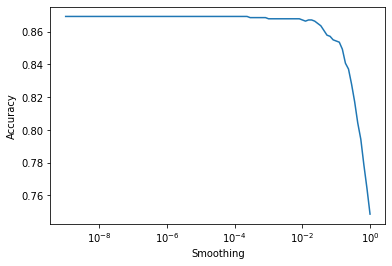

In [10]:
plt.semilogx(np.logspace(0,-9, num=100), gs.cv_results_['mean_test_score'])
plt.ylabel('Accuracy')
plt.xlabel('Smoothing')
plt.savefig('../figures/naive_bayes_smoothing_cv.pdf')

In [11]:
gnb = GaussianNB(var_smoothing=best_params['var_smoothing'])
gnb.fit(X_train, y_train)
y_pred_test=gnb.predict(X_test)
print("Confusion matrix on test set:\n", confusion_matrix(y_test, y_pred_test))
print("\nAccuracy on test set: ", accuracy_score(y_test, y_pred_test))
print("\nBest smoothing: ", best_params['var_smoothing'])

Confusion matrix on test set:
 [[357  51]
 [ 19 173]]

Accuracy on test set:  0.8833333333333333

Best smoothing:  0.0002310129700083158


In [12]:
gnb = GaussianNB(var_smoothing=best_params['var_smoothing'])
gnb.fit(X_train, y_train)
y_pred_train=gnb.predict(X_train)
print("Confusion matrix on test set:\n", confusion_matrix(y_train, y_pred_train))
print("\nAccuracy on test set: ", accuracy_score(y_train, y_pred_train))
print("\nBest smoothing: ", best_params['var_smoothing'])

Confusion matrix on test set:
 [[823 130]
 [ 52 395]]

Accuracy on test set:  0.87

Best smoothing:  0.0002310129700083158


In [13]:
print("Comparing train and test accuracy to see if there is overfitting or underfitting:")
print(f"Train accuracy: {accuracy_score(y_train, y_pred_train)}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test)}")

Comparing train and test accuracy to see if there is overfitting or underfitting:
Train accuracy: 0.87
Test accuracy: 0.8833333333333333


There doesn't seem to be much overfitting or underfitting, the model behaves relatively simalar in both datasets.

### Testing independence of variables

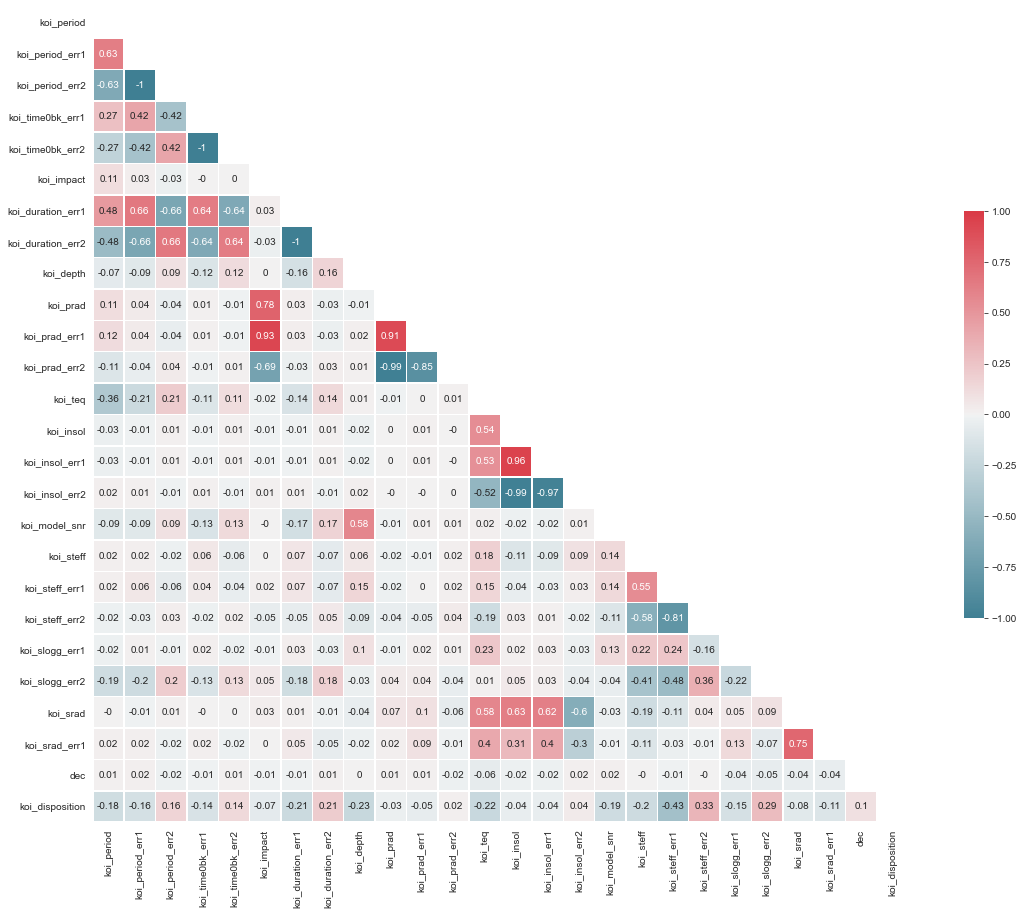

In [14]:
sn.set_style('whitegrid')
corrMatrix = df.corr().round(2)
plt.figure(figsize=(20,15))

mask = np.zeros_like(corrMatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sn.diverging_palette(220, 10, as_cmap=True)

sn.heatmap(corrMatrix, mask=mask, cmap=cmap, center=0, vmax=1, vmin =-1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('../figures/naive_bayes_correlation.pdf')

There are some correlated variables but not as many as we expected. 